## 2nd Project | Trading

###  Instructions
- Follow a Python Project structure.
- Work with a training and validation dataset to optimize & test your trading strategies using the datasets provided in the introduction section.
- Select n technical indicators (one for each team member).
- For each timeframe train/test files (1d, 1h, 5m, 1m):
    - Define buy/sell signals for each indicator.
    - Create all possible combinations of all technical indicators (2^n - 1).
    - Backtest the strategies while keeping track of the operations and cash/portfolio value time series, remember that we'll be opening long & short positions.
    - Optimize all technical indicator's parameters (TPE, Grid Search, PSO, Genetic Algorithms, ...), stop-loss/take-profit, volume of the trade, maximizing the profit of the strategy with the training dataset, consider the bounds of each variable!
    - Select the optimal strategy and describe it thoroughly (what indicators are used, when is the trade signal produced, etc.).
    - Now, use the optimal strategy with the test dataset and compare it to a passive strategy.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta

data = pd.read_csv('aapl_5m_train.csv')

data = data.dropna()

rsi_data = ta.momentum.RSIIndicator(close = data.Close, window= 14)
data['RSI'] = rsi_data.rsi()

short_ma  = ta.trend.SMAIndicator(data.Close, window=5)
long_ma  = ta.trend.SMAIndicator(data.Close, window=21)
data["SHORT_SMA"] = short_ma.sma_indicator()
data["LONG_SMA"] = long_ma.sma_indicator()

macd = ta.trend.MACD(close=data['Close'], window_slow=26, window_fast=12, window_sign=9)
data['MACD'] = macd.macd()
data['Signal_Line'] = macd.macd_signal()

data['SAR'] = ta.trend.PSARIndicator(data['High'], data['Low'], data['Close'], step=0.02, max_step=0.2).psar()

adx_indicator = ta.trend.ADXIndicator(high=data['High'], low=data['Low'], close=data['Close'], window=14)
data['ADX'] = adx_indicator.adx()
data['+DI'] = adx_indicator.adx_pos()
data['-DI'] = adx_indicator.adx_neg()
data['prev_DI+'] = data['+DI'].shift(1)
data['prev_DI-'] = data['-DI'].shift(1)

data = data.dropna()

In [10]:
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,RSI,SHORT_SMA,LONG_SMA,MACD,Signal_Line,SAR,ADX,+DI,-DI,prev_DI+,prev_DI-
33,33,1609780500,0,2021-01-04 17:15:00,127.410003,128.029998,126.760002,128.005004,2891333.0,26.712155,128.233343,129.705785,-0.872535,-0.728380,128.770004,73.503071,3.365347,46.382888,3.964850,45.666999
34,34,1609780800,0,2021-01-04 17:20:00,128.000793,128.399993,127.750000,128.289993,1956101.0,31.714234,128.127340,129.571257,-0.856193,-0.753943,126.760002,73.269762,7.485484,42.814693,3.365347,46.382888
35,35,1609781100,0,2021-01-04 17:25:00,128.289993,128.320007,127.889999,128.250000,1331407.0,31.390449,128.061340,129.438161,-0.836823,-0.770519,126.760002,73.053118,7.096538,40.590038,7.485484,42.814693
36,36,1609781400,0,2021-01-04 17:30:00,128.246902,128.310104,127.910003,128.119995,1314757.0,30.307246,128.014999,129.312928,-0.822481,-0.780911,126.792802,72.851949,6.745340,38.581294,7.096538,40.590038
37,37,1609781700,0,2021-01-04 17:35:00,128.125000,128.210006,127.889999,127.955001,982464.0,28.942233,128.123999,129.181748,-0.815033,-0.787736,126.824946,72.677574,6.469565,37.259515,6.745340,38.581294


### RSI

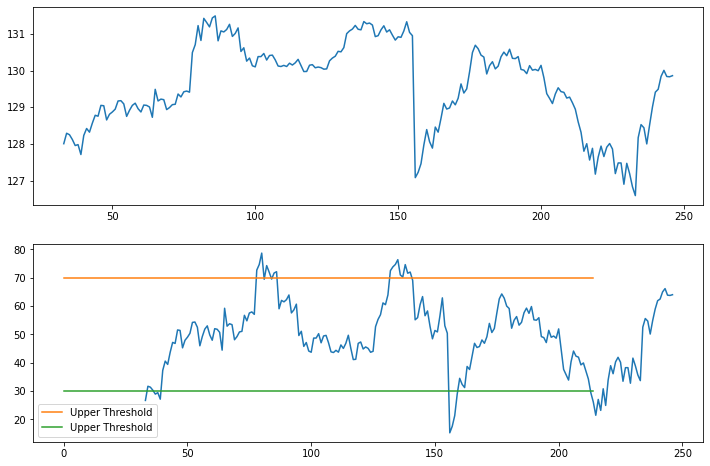

In [11]:
fig, axs = plt.subplots(2, 1, figsize = (12,8))


axs[0].plot(data.Close[:214])


axs[1].plot(data.RSI[:214])
axs[1].plot([0, 214], [70,70], label = "Upper Threshold")
axs[1].plot([0, 214], [30,30], label = "Upper Threshold")
plt.legend()

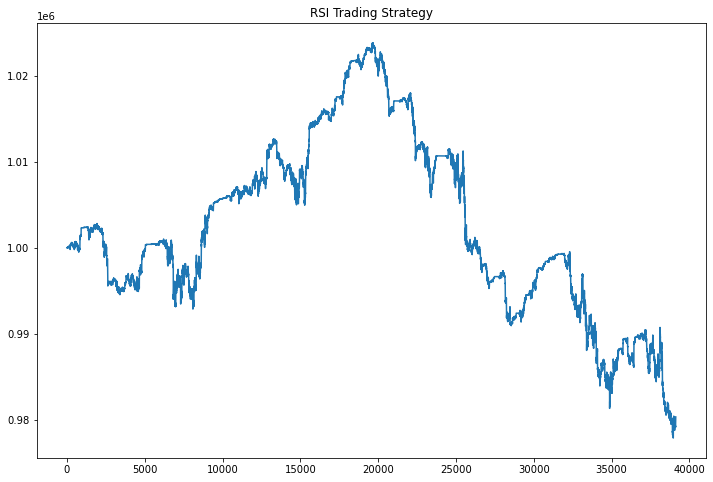

In [12]:
class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.sold_at = None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10

for i, row in data.iterrows():
    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close:
            cash += row.Close * op.n_shares * (1 - com)  
        elif op.take_profit < row.Close: # Close profit
            cash += row.Close * op.n_shares *  (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations
    
    if cash > row.Close * n_shares * (1 + com):   
        # Buy signal
        if row.RSI < 30:
            active_operations.append(Operation(operation_type = 'long', 
                                               bought_at = row.Close, 
                                               timestamp = row.Timestamp, 
                                               n_shares = n_shares,
                                               stop_loss = row.Close * 0.95,
                                               take_profit = row.Close * 1.05))
            cash -= row.Close * n_shares *  (1 + com)
            
    else:
        print('no money available..')
    
    total_value = len(active_operations) * row.Close * n_shares
    strategy_value.append(cash + total_value)
        
        
plt.figure(figsize = (12, 8))
plt.plot(strategy_value)
plt.title('RSI Trading Strategy')
plt.show()

### SMA

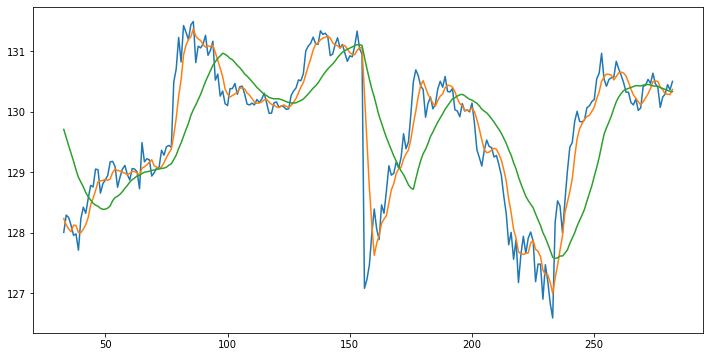

In [13]:
plt.figure(figsize = (12, 6))
plt.plot(data.Close[:250], label = 'price')
plt.plot(data.SHORT_SMA[:250], label = 'SAM(5)')
plt.plot(data.LONG_SMA[:250], label = 'SMA(21)')

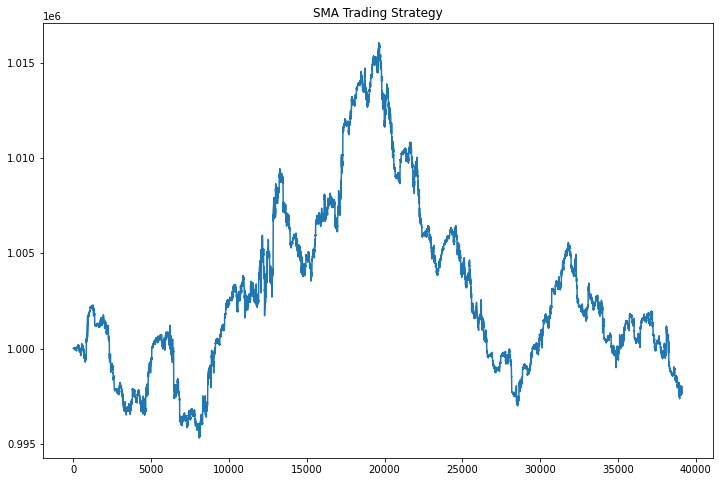

In [14]:
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10

sma_sell_signal = data.iloc[0].LONG_SMA > data.iloc[0].SHORT_SMA 
sma_buy_signal = data.iloc[0].LONG_SMA < data.iloc[0].SHORT_SMA


for i, row in data.iterrows():
    # Close operations
    temp_operations = []
    for op in active_operations:
        # Close losing position
        if op.stop_loss > row.Close:
            cash += row.Close * op.n_shares * (1 - com)  
        elif op.take_profit < row.Close: # Close profit
            cash += row.Close * op.n_shares *  (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations
    
    if cash > row.Close * n_shares * (1 + com):   
        # Buy signal
        if (row.LONG_SMA < row.SHORT_SMA) and SMA_buy_signal == False:
            SMA_buy_signal =True
            #buy....
            active_operations.append(Operation(operation_type = 'long', 
                                               bought_at = row.Close, 
                                               timestamp = row.Timestamp, 
                                               n_shares = n_shares,
                                               stop_loss = row.Close * 0.95,
                                               take_profit = row.Close * 1.05))
            cash -= row.Close * n_shares *  (1 + com)
            
        elif row.LONG_SMA > row.SHORT_SMA:
            SMA_buy_signal =False
        
            
    else:
        print('no money available..')
    
    total_value = len(active_operations) * row.Close * n_shares
    strategy_value.append(cash + total_value)
    
    
plt.figure(figsize = (12, 8))
plt.plot(strategy_value)
plt.title('SMA Trading Strategy')
plt.show()

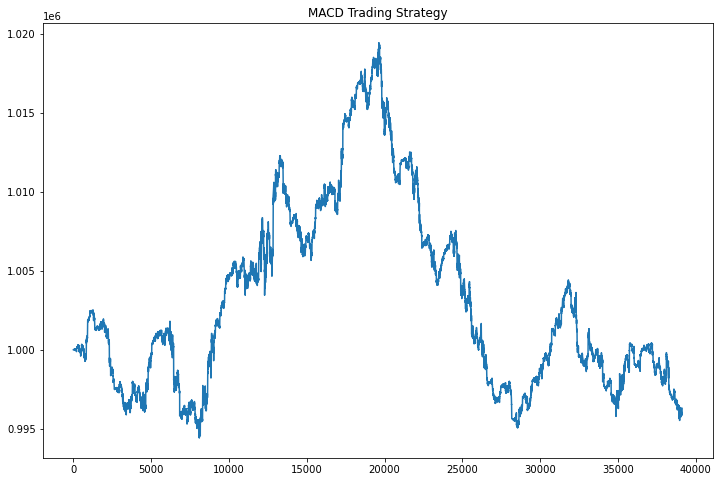

In [15]:
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10

for i, row in data.iterrows():
    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close: 
            cash += row.Close * op.n_shares * (1 - com)
        elif op.take_profit < row.Close:  
            cash += row.Close * op.n_shares * (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations
    
    # Verificamos si tenemos suficiente efectivo
    if cash > row.Close * n_shares * (1 + com):
        # Señal de compra: la línea MACD cruza por encima de la línea de señal
        prev_macd = data['MACD'].shift(1)[i]  # Valor MACD de la fila anterior
        prev_signal = data['Signal_Line'].shift(1)[i]  # Valor de la línea de señal de la fila anterior
        if row['MACD'] > row['Signal_Line'] and prev_macd < prev_signal:
            active_operations.append(Operation(operation_type='long',
                                                bought_at=row.Close,
                                                timestamp=row.Timestamp,
                                                n_shares=n_shares,
                                                stop_loss=row.Close * 0.95,
                                                take_profit=row.Close * 1.05))
            cash -= row.Close * n_shares * (1 + com)
    else:
        print('no money available..')
    
    
    total_value = len(active_operations) * row.Close * n_shares
    strategy_value.append(cash + total_value)


plt.figure(figsize=(12, 8))
plt.plot(strategy_value)
plt.title('MACD Trading Strategy')
plt.show()

In [45]:
exp1 = data['Close'].ewm(span=12, adjust=False).mean()
exp2 = data['Close'].ewm(span=26, adjust=False).mean()
data['MACD'] = exp1 - exp2
data['Signal line'] = data['MACD'].ewm(span=9, adjust=False).mean()
data.tail()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,RSI,...,MACD,Signal_Line,SAR,ADX,+DI,-DI,prev_DI+,prev_DI-,prev_SAR,Signal line
39573,19787,1672432500,0,2022-12-30 20:35:00,129.020004,129.050003,128.899993,129.039993,773964.0,65.879195,...,0.137293,0.045704,128.391187,28.525374,26.848508,11.804718,28.146415,12.375380,128.322595,0.045704
39574,19788,1672432800,0,2022-12-30 20:40:00,129.029998,129.130004,128.919998,129.054992,833767.0,66.256388,...,0.151129,0.066789,128.454292,29.547598,27.579529,11.037387,26.848508,11.804718,128.391187,0.066789
39575,19789,1672433100,0,2022-12-30 20:45:00,129.059997,129.399993,129.020004,129.380004,2136910.0,73.176111,...,0.186174,0.090666,128.512348,31.268525,32.466832,9.796526,27.579529,11.037387,128.454292,0.090666
39576,19790,1672433400,0,2022-12-30 20:50:00,129.375000,129.929992,129.330001,129.764404,2879267.0,78.731380,...,0.242174,0.120968,128.601112,33.811895,41.432915,8.224302,32.466832,9.796526,128.512348,0.120968
39577,19791,1672433700,0,2022-12-30 20:55:00,129.764999,129.949996,129.619995,129.949996,3896812.0,80.798987,...,0.298093,0.156393,128.760578,36.200736,38.362421,7.510367,41.432915,8.224302,128.601112,0.156393


(-1.0, 1.0)

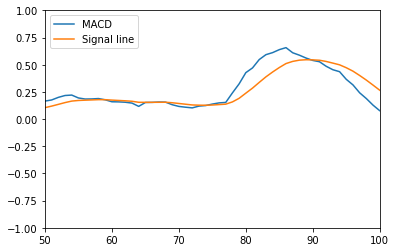

In [48]:
fig, ax = plt.subplots()
data[['MACD', 'Signal line']].plot(ax=ax)
plt.xlim(50,100)
plt.ylim(-1,1)

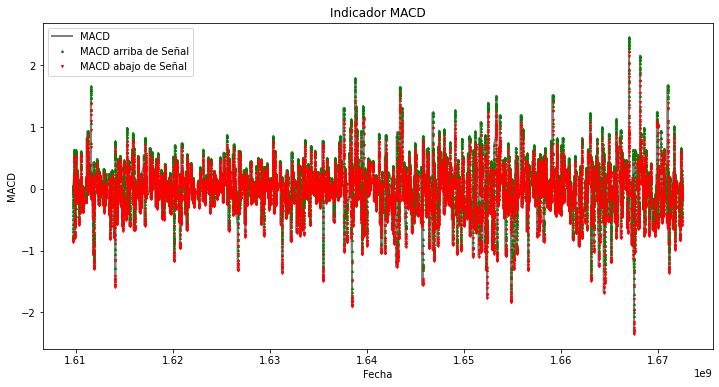

In [32]:
# Crear una figura para el indicador MACD
plt.figure(figsize=(12, 6))

# Graficar el indicador MACD
plt.plot(data['Timestamp'], data['MACD'], label='MACD', color='grey', linewidth=2)

# Identificar cambios de tendencia
macd_above_signal = data['MACD'] > data['Signal_Line']
macd_below_signal = data['MACD'] < data['Signal_Line']

# Cambiar el color del MACD cuando cambia de tendencia
plt.plot(data.loc[macd_above_signal, 'Timestamp'], data.loc[macd_above_signal, 'MACD'], '^', markersize=2, color='green', label='MACD arriba de Señal')
plt.plot(data.loc[macd_below_signal, 'Timestamp'], data.loc[macd_below_signal, 'MACD'], 'v', markersize=2, color='red', label='MACD abajo de Señal')

# Añadir título y leyenda
plt.title('Indicador MACD')
plt.xlabel('Fecha')
plt.ylabel('MACD')
plt.legend()

# Mostrar la gráfica
plt.show()


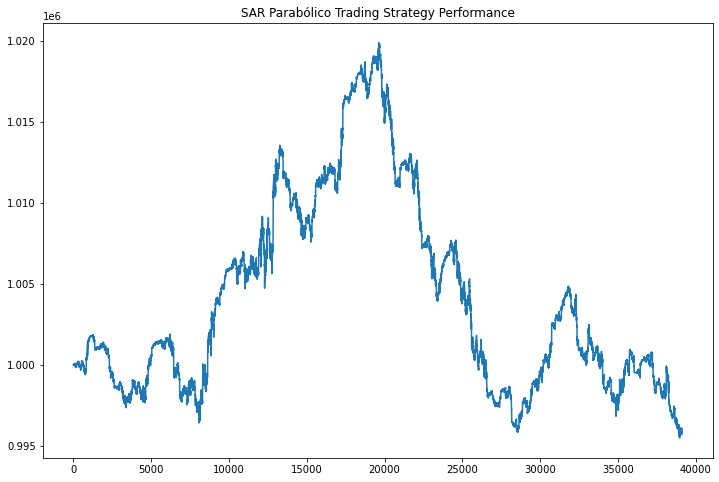

In [16]:
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10
data['prev_SAR'] = data['SAR'].shift(1)

for index, row in data.iterrows():

    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close or op.take_profit < row.Close:
            cash += row.Close * op.n_shares * (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations

    if cash > row.Close * n_shares * (1 + com):
        # Señal de compra: puntos del SAR pasan de estar arriba a debajo del precio
        if pd.notnull(row['prev_SAR']):  # Asegura que el valor previo de SAR no sea NaN
            if row['SAR'] < row['Close'] and row['prev_SAR'] > row['Close']:
                active_operations.append(Operation('long', row.Close, row.Timestamp, n_shares, row.Close * 0.95, row.Close * 1.05))
                cash -= row.Close * n_shares * (1 + com)

    
    total_value = sum(op.n_shares * row.Close for op in active_operations)
    strategy_value.append(cash + total_value)


plt.figure(figsize=(12, 8))
plt.plot(strategy_value)
plt.title('SAR Parabólico Trading Strategy Performance')
plt.show()

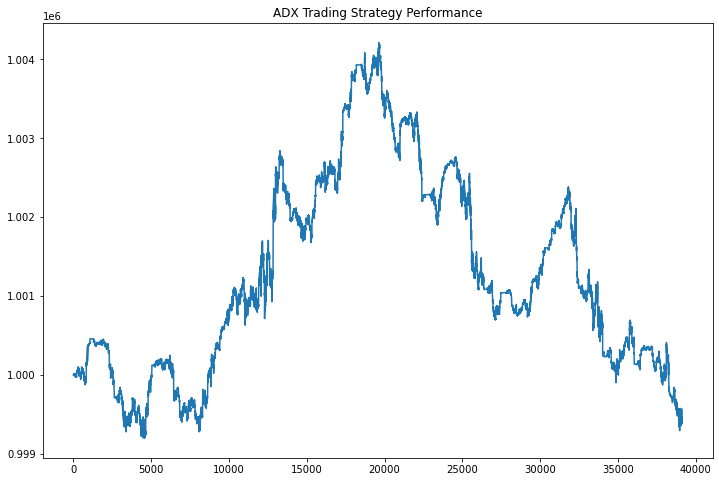

In [17]:

data = data.dropna()

cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [1_000_000]
n_shares = 10

for index, row in data.iterrows():
    temp_operations = []
    for op in active_operations:
        if op.stop_loss > row.Close or op.take_profit < row.Close:
            cash += row.Close * op.n_shares * (1 - com)
        else:
            temp_operations.append(op)
    active_operations = temp_operations

    if cash > row.Close * n_shares * (1 + com):
        # Señal de compra
        if pd.notnull(row['prev_DI+']) and pd.notnull(row['prev_DI-']):  # Verifica que los valores previos no sean NaN
            if row['+DI'] > row['-DI'] and row['ADX'] > 25 and row['prev_DI+'] < row['prev_DI-']:
                active_operations.append(Operation('long', row.Close, row.Timestamp, n_shares, row.Close * 0.95, row.Close * 1.05))
                cash -= row.Close * n_shares * (1 + com)


    total_value = sum(op.n_shares * row.Close for op in active_operations)
    strategy_value.append(cash + total_value)


plt.figure(figsize=(12, 8))
plt.plot(strategy_value)
plt.title('ADX Trading Strategy Performance')
plt.show()

### Bolinger Bands

In [18]:
data_2 = pd.read_csv('data/aapl_1m_train.csv')
data_2 = data_2.dropna()
data_2

FileNotFoundError: [Errno 2] No such file or directory: 'data/aapl_1m_train.csv'

In [ ]:
df = data_2.copy()

In [ ]:
df

In [ ]:
df = df.drop(['Unnamed: 0', 'Timestamp', 'Gmtoffset'], axis=1)

In [ ]:
df

In [ ]:
window = 30
no_of_std = 1.5

# calculate rolling mean and standard deviation
rolling_mean = df['Close'].rolling(window).mean()
rolling_std = df['Close'].rolling(window).std()

# create two new DataFrame columns to hold values of upper and lower Bollinger bands
df['Rolling Mean'] = rolling_mean
df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)


In [ ]:
df.tail()

In [ ]:
plt.figure(figsize=(10, 6))

# Plotea las columnas Close, Bollinger High y Bollinger Low
df[['Datetime', 'Close', 'Bollinger High', 'Bollinger Low']].plot()

# Muestra el gráfico
plt.show()

In [ ]:
ax = df[['Close', 'Bollinger High', 'Bollinger Low']].plot(figsize=(10, 6))

# Muestra el gráfico
plt.ylim(124,132)
plt.xlim(0,2000)
plt.show()